In [37]:
import random
import math
import time
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [39]:
INPUT_PATH = "/content/drive/MyDrive/CAT_06"
img_path_list = glob.glob(os.path.join(INPUT_PATH, '*'))
print(len(img_path_list))

1388


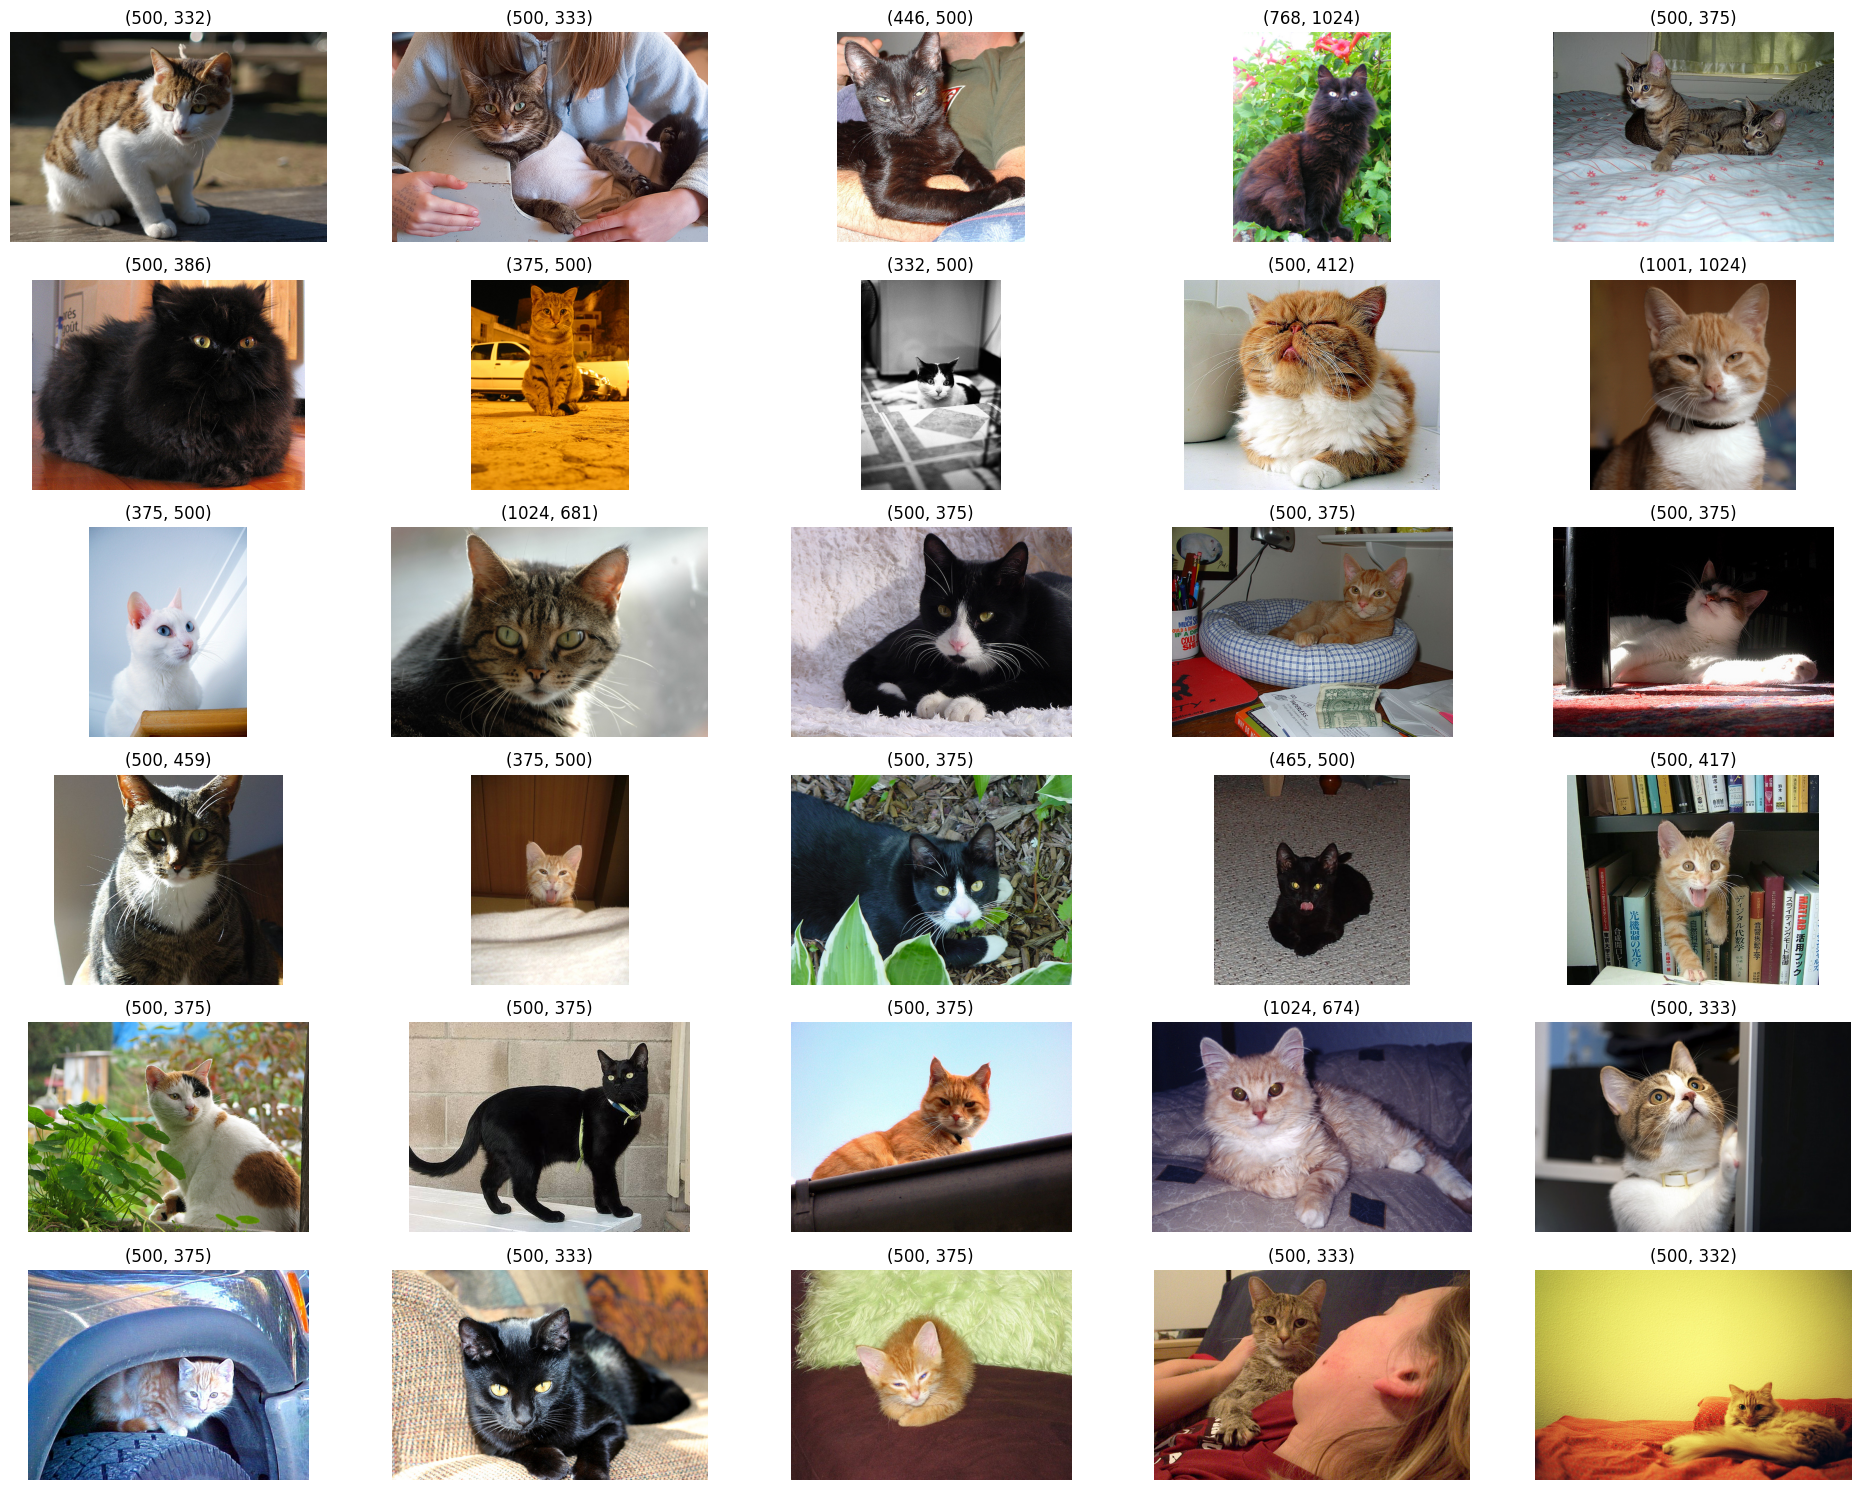

In [40]:
plt.figure(figsize=(20,15),tight_layout = True)
for i in range(30):
    plt.subplot(6,5,i+1)
    img = Image.open(img_path_list[i])
    plt.imshow(img)
    plt.axis("OFF")
    plt.title(img.size)

In [41]:
def seed_everything():
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
seed_everything()

In [42]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size = 64):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, # Potential Dimension in_channle
                               image_size*8, #  out_channel
                               kernel_size = 4,
                               stride = 1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, # Potential Dimension in_channle
                               image_size*4, #  out_channel
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4,
                               image_size * 2,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2,
                               image_size,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size,
                               3, #Since it is a color image, I will leave it at 3 here.
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.Tanh())

    def forward(self, z):
        '''
        Save the shape in print for bug damage
        '''
        #print(f"z_shape :{z.shape}")
        out = self.layer1(z)
        #print(f"layer1_out_shape : {out.shape}")
        out = self.layer2(out)
        #print(f"layer2_out_shape : {out.shape}")
        out = self.layer3(out)
        #print(f"layer3_out_shape : {out.shape}")
        out = self.layer4(out)
        #print(f"layer4_out_shape : {out.shape}")
        out = self.last(out)
        #print(f"layer5_out_shape : {out.shape}")
        return out

fake_img_shape:torch.Size([1, 3, 64, 64])


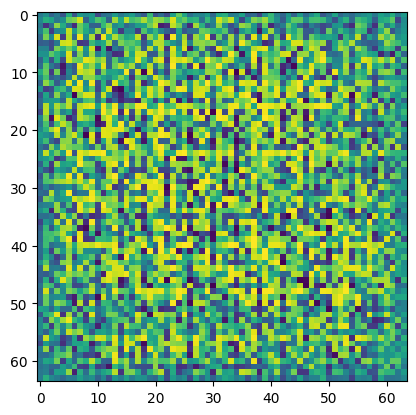

In [43]:
# Confirmation of operation
G = Generator(z_dim = 20, image_size = 64)
# random number
input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1,1)
# output
fake_images = G(input_z)
print(f"fake_img_shape:{fake_images.shape}")


img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed)
plt.show()

In [44]:
class Discriminator(nn.Module):
    def __init__(self,image_size = 64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, # Since the in_channel is color, 3
                      image_size,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size,
                      image_size*2,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2,
                      image_size*4,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4,
                      image_size*8,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        return out

In [45]:
# Confirmation of operation
D = Discriminator(image_size=64)

# Generate fake images
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# Input a fake image into D
d_out = D(fake_images)

# Multiply the output d_out by Sigmoid and convert it from 0 to 1
print(nn.Sigmoid()(d_out))

tensor([[[[0.5033]]]], grad_fn=<SigmoidBackward0>)


In [46]:
def make_img_path_list(use_dir_num):
    '''
    The image storage folder is CAT06. Specify how far to use and return a list of image paths up to that point
    '''
    train_img_list = []
    # for i in range(use_dir_num):
    use_dir = f"/content/drive/MyDrive/CAT_06"
    paths = glob.glob(os.path.join(use_dir,"*"))
    train_img_list+=paths
    print("num_img",len(train_img_list))
    return train_img_list

In [47]:
train_img_list = make_img_path_list(7)

num_img 1388


In [48]:
# transform
IMG_MEAN = [0.5, 0.5, 0.5]
IMG_STD = [0.5, 0.5, 0.5]
size = (64,64)

data_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

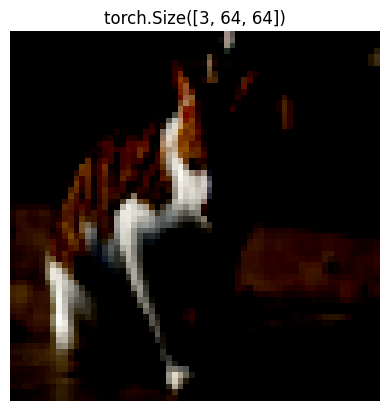

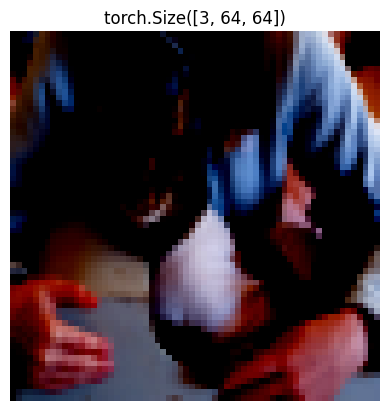

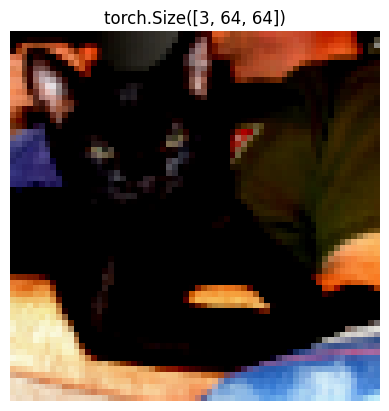

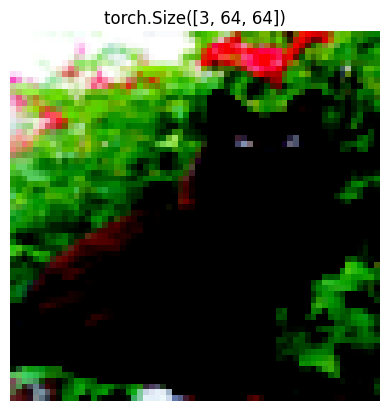

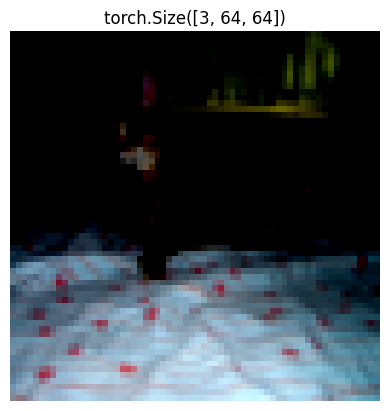

In [49]:
# Transform operation check
for i in range(5):
    img = Image.open(img_path_list[i])
    x = data_transform(img)
    plt.title(x.shape)
    plt.imshow(x.permute(1,2,0))
    plt.axis("off")
    plt.show()

In [50]:
# dataset class
class GAN_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img = self.transform(img)
        return img

In [51]:
# Creating a Data Loader and Checking Its Operation
dataset = GAN_Dataset(
    file_list=train_img_list,
    transform=data_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

# Create a Data Loader
batch_size = 64

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=True)

# batch_size = 64

# train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Verify that it works
batch_iterator = iter(train_dataloader)  # Convert to Iterator
imges = next(batch_iterator)  # Take out the first element
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 3, 64, 64])


In [52]:
# Initialize the network
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Initializing Conv2d and ConvTranspose2d
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # Initializing BatchNorm2d
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [53]:
# Assuming you have lists to store losses:
val_losses = {'G': [], 'D': []}
train_losses = {'G': [], 'D': []}

In [68]:
def train_model(G, D, dataloader, val_dataloader, num_epochs, device):
    # Setting up the optimization method
    g_lr, d_lr = 0.0005, 0.0005
    beta1, beta2 = 0.1, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # Define error function
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # Hard-coded parameters
    z_dim = 20
    mini_batch_size = 64

    # Network to GPU
    G.to(device)
    D.to(device)

    G.train()  # Put the model in training mode
    D.train()  # Put the model in training mode

    # If the network is fixed to some extent, speed it up
    torch.backends.cudnn.benchmark = True

    # Number of images
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # Set Iteration Counter
    iteration = 1
    logs = []

    # Looping epoch
    for epoch in range(num_epochs):

        # Save start time
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # Loss sum of epoch
        epoch_d_loss = 0.0  # Loss sum of epoch

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # Loop to retrieve minibatches from the data loader
        for images in dataloader:

            # --------------------
            # 1. Discriminator Learning
            # --------------------
            # If the size of the mini-batch is 1, it will cause an error in batch normalization, so avoid it.
            if images.size()[0] == 1:
                continue

            # If the GPU is available, send the data to the GPU.
            images = images.to(device)

            # Create Correct and False Labels
            real_labels = torch.ones(images.size(0), 1).to(device)
            fake_labels = torch.zeros(images.size(0), 1).to(device)

            # Discriminator Loss with Real Images
            outputs = D(images).view(-1, 1)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Generate Fake Images
            z = torch.randn(images.size(0), z_dim).to(device)
            z = z.view(z.size(0), z_dim, 1, 1)  # Reshape noise vector to 4D tensor
            fake_images = G(z)

            # Discriminator Loss with Fake Images
            outputs = D(fake_images).view(-1, 1)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Backpropagation and Optimization
            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator Learning
            # --------------------
            # Generate Fake Images
            z = torch.randn(images.size(0), z_dim).to(device)
            z = z.view(z.size(0), z_dim, 1, 1)  # Reshape noise vector to 4D tensor
            fake_images = G(z)
            outputs = D(fake_images).view(-1, 1)

            # Generator Loss
            g_loss = criterion(outputs, real_labels)

            # Backpropagation and Optimization
            G.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # 3. record
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

            train_losses['G'].append(epoch_g_loss / len(train_dataloader))
            train_losses['D'].append(epoch_d_loss / len(train_dataloader))
        # Validation phase
        G.eval()
        D.eval()
        val_g_loss = 0.0
        val_d_loss = 0.0
        with torch.no_grad():
            for i, real_images in enumerate(val_dataloader):
                real_images = real_images.to(device)
                batch_size = real_images.size(0)

                # Create labels
                real_labels = torch.ones(batch_size, 1).to(device)
                fake_labels = torch.zeros(batch_size, 1).to(device)

                # Validate the Discriminator with real images
                outputs = D(real_images).view(-1, 1)
                lossD_real = criterion(outputs, real_labels)

                # Validate the Discriminator with fake images
                noise = torch.randn(batch_size, z_dim).to(device)
                noise = noise.view(noise.size(0), z_dim, 1, 1)  # Reshape noise vector to 4D tensor
                fake_images = G(noise)
                outputs = D(fake_images).view(-1, 1)
                lossD_fake = criterion(outputs, fake_labels)

                lossD = lossD_real + lossD_fake
                val_d_loss += lossD.item()

                # Validate the Generator
                outputs = D(fake_images).view(-1, 1)
                lossG = criterion(outputs, real_labels)

                val_g_loss += lossG.item()

        val_d_loss /= len(val_dataloader)
        val_g_loss /= len(val_dataloader)

        val_losses['G'].append(val_g_loss / len(val_dataloader))
        val_losses['D'].append(val_d_loss / len(val_dataloader))

        # Print loss
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} || Val_D_Loss:{:.4f} || Val_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/len(dataloader), epoch_g_loss/len(dataloader), val_d_loss, val_g_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))

    return G, D


In [69]:
## Perform training and validation
# Performing Initialization

G = Generator(z_dim = 20, image_size = 64)
D = Discriminator(image_size=64)

G.apply(weights_init)
D.apply(weights_init)
print("Network Initialization Completed")

num_epochs = 20
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, val_dataloader= val_dataloader, num_epochs=num_epochs, device = device)

Network Initialization Completed
-------------
Epoch 0/20
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.8377 ||Epoch_G_Loss:1.4685 || Val_D_Loss:0.2022 || Val_G_Loss:2.4510
timer:  109.8755 sec.
-------------
Epoch 1/20
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:1.3453 ||Epoch_G_Loss:3.4202 || Val_D_Loss:0.2492 || Val_G_Loss:1.6785
timer:  105.7145 sec.
-------------
Epoch 2/20
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.3516 ||Epoch_G_Loss:2.6256 || Val_D_Loss:0.3018 || Val_G_Loss:2.7195
timer:  105.2722 sec.
-------------
Epoch 3/20
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:3.3146 ||Epoch_G_Loss:2.8830 || Val_D_Loss:0.4797 || Val_G_Loss:1.0313
timer:  106.3363 sec.
-------------
Epoch 4/20
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.7093 ||Epoch_G_Loss:2.0741 || Val_D_Loss:0.6883 || Val_G_Loss:0.9341
timer:  105.3882 sec.
-------------
Epoch 5/20
-------------
（train）
-------------
epoch 5 || Epoch

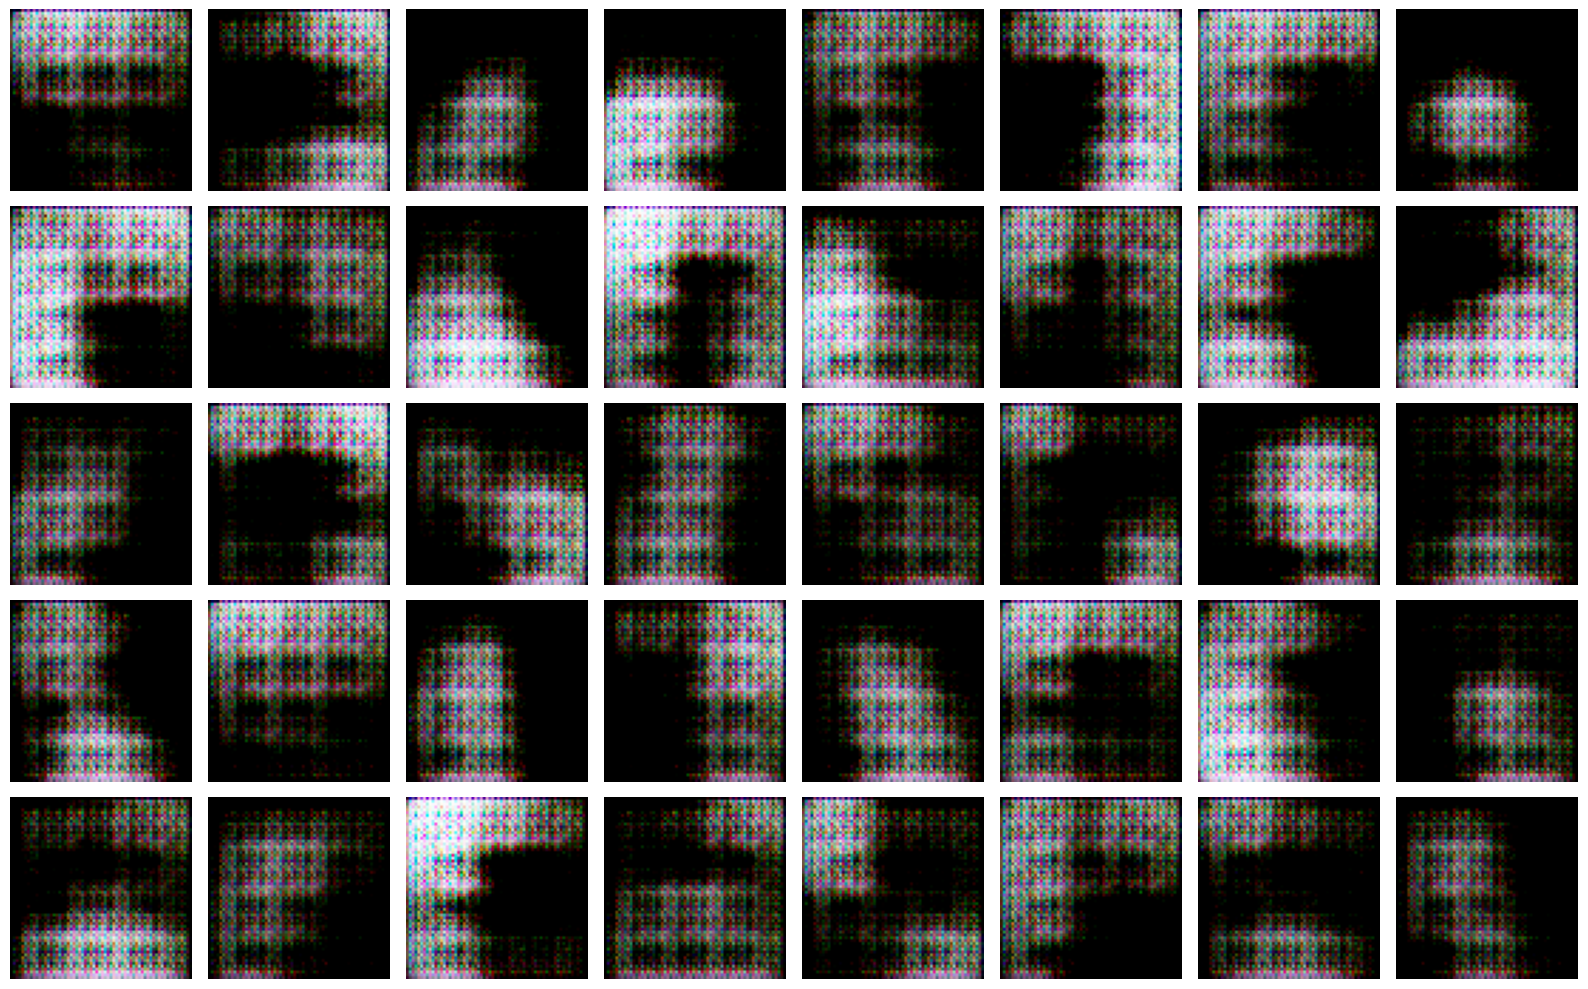

In [70]:
# Visualize generated images and training data
# This cell is re-run many times until a good image is generated.

# Input Random Number Generation
batch_size = 40
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# Image Generation
fake_images = G_update(fixed_z.to(device))

# output
fig = plt.figure(figsize=(16, 10),tight_layout = True)
for i in range(0, 40):
    plt.subplot(5, 8, i+1)
    plt.imshow(fake_images[i].cpu().detach().permute(1,2,0))
    plt.axis("off")

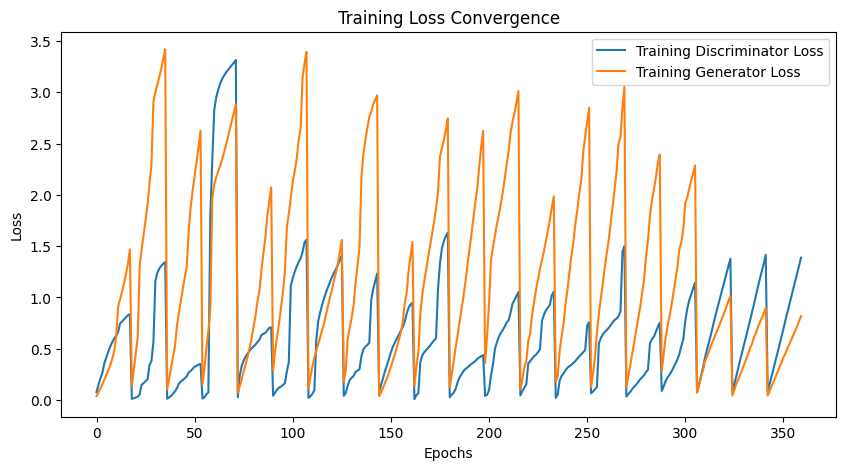

In [77]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses['D'], label='Training Discriminator Loss')
# plt.plot(val_losses['D'], label='Validation Discriminator Loss')
plt.plot(train_losses['G'], label='Training Generator Loss')
# plt.plot(val_losses['G'], label='Validation Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Convergence')
plt.show()

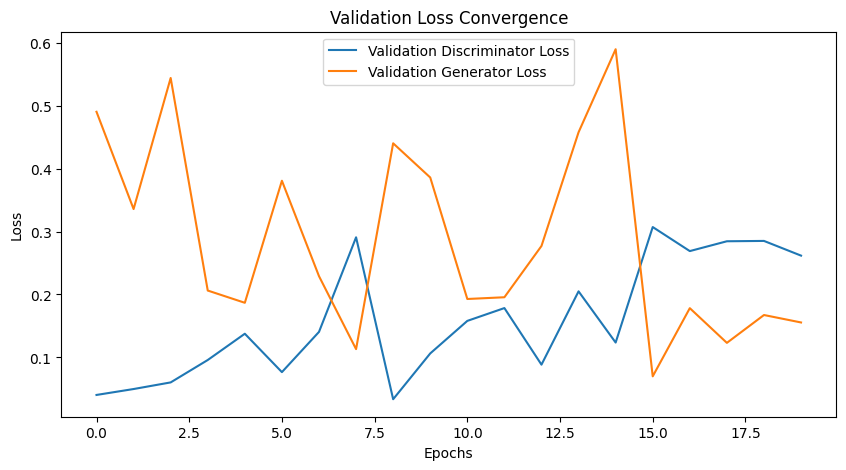

In [78]:

plt.figure(figsize=(10, 5))
# plt.plot(train_losses['D'], label='Training Discriminator Loss')
plt.plot(val_losses['D'], label='Validation Discriminator Loss')
# plt.plot(train_losses['G'], label='Training Generator Loss')
plt.plot(val_losses['G'], label='Validation Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Convergence')
plt.show()